# Derivative verification
Here we use the API to compute derivative components
and compare the results to difference quotient approximations.

In [1]:
import numpy as np
import scipy.sparse as sps
import pandas as pd
import product_fem as pf
import fenics as fx
import matplotlib.pyplot as plt

In [2]:
def remainders(h):
    pfm = pf.Function(V, dim=2)
    pfm.assign(m)
    control = pf.Control([pfm])
    L  = L2Regularizer(control, [1.0])
    dL = [fx.assemble(form) for form in L.derivative(control)]
    Lm = L.evaluate(control)
    Lpert = []
    for i in range(len(pfm.basis)):
        if i==0:
            m_new = pfm + h * pfm.basis[i]
            control.update(m_new.array())
            Lpert.append(L.evaluate(control))
        else:
            m_new = pfm - h * pfm.basis[i-1] + h * pfm.basis[i]
            control.update(m_new.array())
            Lpert.append(L.evaluate(control))
    
    return [abs(Lpert[i] - Lm - h * dL[i]) for i in range(len(dL))]

## Testing $\frac{\partial A}{\partial m}$

In [3]:
n = 5
mesh = fx.UnitSquareMesh(n-1, n-1)
V = fx.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)
eqn = pf.equations.HittingTimes(W, u_bdy=0.3, epsilon=1e-2)
mu, sig = m = eqn.control

def init_control():
    mu_arr = np.ones(mu.dim())
    sig_arr = np.zeros(sig.dim())
    sig_arr[::3] = np.log(0.25)
    sig_arr[1::3] = np.log(0.25)
    m_arr = np.concatenate((mu_arr, sig_arr))
    return m_arr

def eqn_component_error(i, m_name='mu'):
    # initialize control
    m.update(init_control())
    u = eqn.solve(m) # solve with initial parameters
    A = eqn.A.copy()
    h = 1e-4
    
    mu, sig = m
    if m_name=='mu':
        dAdm, _ = eqn.derivative_component(i, mu)
        mu.vector()[:] += h * np.eye(mu.dim())[i]
    elif m_name=='sig':
        dAdm, _ = eqn.derivative_component(i, sig)
        sig.vector()[:] += h * np.eye(sig.dim())[i]
        
#     m.update([mu, sig])
    u_pert = eqn.solve(m)
    A_pert = eqn.A.copy()
    dA_diff = A_pert / h - A / h
    
    return sps.linalg.norm(dAdm - dA_diff)

def plot_eqn_component_error(m_name='mu'):
    fig, ax = plt.subplots()
    if m_name=='mu':
        mu = m[0]
        errs = [eqn_component_error(i, m_name) for i in range(mu.dim())]
    elif m_name=='sig':
        sig = m[1]
        errs = [eqn_component_error(i, m_name) for i in range(sig.dim())]
        
    log_err = -np.log10(errs)
    ax.scatter(x=[i for i in range(len(log_err))], y=log_err)
    ax.set_ylabel(r'$-\log(\mathrm{error})$')
    plt.show()

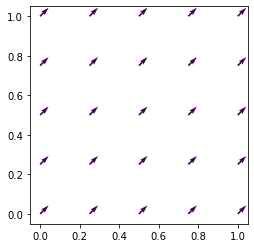

In [4]:
m.update(init_control())
m[0].plot()

In [5]:
# plot_eqn_component_error('mu')

In [6]:
# plot_eqn_component_error('sig')

## Testing $\frac{\partial J}{\partial m}$

In [35]:
def setup_loss(m):
    data = eqn.solve(m)
    reg = {'l2': [1e-6, 1e-4], 'smoothing': [1e-1, 1e-1]}
#     reg = {'l2': [1e-11, 1e-11], 'smoothing': [1e-11, 1e-11]}
    loss = pf.LossFunctional(data, m, reg)
    return loss

loss = setup_loss(m)

def loss_component_error(i, m_name='mu'):
    m.update(init_control())
    J = loss.evaluate(loss.data, m)

    h = 1e-7
    mu, sig = m
    if m_name=='mu':
        dJdm = loss.derivative_component(i, mu)
        mu.vector()[:] += h * np.eye(mu.dim())[i]
    elif m_name=='sig':
        dJdm = loss.derivative_component(i, sig)
        sig.vector()[:] += h * np.eye(sig.dim())[i]
        
#     m.update([mu, sig])
    J_pert = loss.evaluate(loss.data, m)
    J_diff = J_pert / h - J / h

    return abs(dJdm - J_diff)

def plot_loss_component_error(m_name='mu'):
    fig, ax = plt.subplots()
    if m_name=='mu':
        errs = [loss_component_error(i, m_name) for i in range(mu.dim())]
    elif m_name=='sig':
        errs = [loss_component_error(i, m_name) for i in range(sig.dim())]
        
    log_err = -np.log10(errs)
    ax.scatter(x=[i for i in range(len(log_err))], y=log_err)
    ax.set_ylabel(r'$-\log(\mathrm{error})$')
    plt.show()

In [36]:
# plot_loss_component_error('mu')

In [37]:
# plot_loss_component_error('sig')

In [38]:
# the ij component of l2_error.derivative(u) should be equal to
# int (u - u_d) phi_i phi_j dxdy
# m.update(m.array() * 0.1)
# u = eqn.solve(m)
# loss.l2_error.derivative(u)

### Test L^2 error derivative
The L2 error functional is $J(u) = \frac{1}{2}\int(u-u_d)^2 dxdy$,
so its derivative in the arbitrary direction of $v$ is
$J_u(v) = \int(u-u_d)v dxdy$. We can compute this for each of $v$s
basis elements and compare this to the central difference

$$
    J_u(v) \approx \frac{J(u + hv) - J(u - hv)}{2h}
$$

When $v$ is the product basis element
$\phi_i(x)\phi_j(y)$ the directional derivative should be 

$$
J_u(\phi_i\phi_j) = \sum_{k\ell}r_{k\ell}\int\phi_k\phi_i dx \int \phi_\ell\phi_j dy
$$

## Taylor Test
Here we demonstrate how we can rigorously verify the output of 
`invp.compute_gradient(m)` is indeed equal to $\nabla_m J$.
Let $h$ be an arbitary function in the same space as $m$, so we may
view $m+h$ as a perturbation of $m$.
The Taylor Remainder Theorem gives us the theoretical convergence rate
in the limit where $h$ becomes identically zero. It states:
there exists some constant $C$ such that 
$$
    |J(m+h) - J(m) - \nabla_m J(h)| = C\|h\|^2.
$$

In the above, $\nabla_m J(h)$ is the gradient of $J$ at the function $m$
in the direction of $h$. Given $\nabla_m J$ and $h$ separately, we have
$\nabla_m J(h) = \int_\Omega\! \nabla_m J h \,dx$.
With this in mind, let $h = \epsilon \tilde m$ for arbitrary $\tilde m$.
This way we need only consider the limit $\epsilon\to 0$.
In particular let's take this limit using the sequence 
$\epsilon, \frac{\epsilon}{c}, \frac{\epsilon}{c^2}, \ldots$
for any choice of $c>1$. Now, define
$$
    R_\epsilon = |J(m+\epsilon\tilde m) - J(m) - \nabla_m J(\epsilon\tilde m)|
$$
and note that $R_\epsilon = C\|\epsilon\tilde m\|^2 = \epsilon^2 C\|\tilde m\|^2$.
Hence,
$$
    \frac{R_{\epsilon / c^{k}}}{R_{\epsilon / c^{k+1}}}
    =
    c^2,
$$
and we can take logs to obtain
$$
    \frac{\log(R_\epsilon / R_{\epsilon/c})}{\log c} = 2.
$$
For numerical tests we can fix some $\epsilon$ and then for any given $c>1$
verify closeness to the above equation.

In [39]:
Jhat = pf.ReducedLossFunctional(eqn, loss)

In [40]:
def remainders(h):
    # initialize control
    m.update(init_control())
    
    # evaluate loss at control
    Jm = Jhat(m)
    
    # compute loss derivatives
    dJ = loss.derivative(m)
    
    # perturb control with basis functions
    e = np.eye(m.dim())
    Jp = []
    for i in range(m.dim()):
        if i==0:
            m_new = m.array() + h * e[i]
        else:
            m_new = m.array() - h * e[i-1] + h * e[i]
        m.update(m_new)
        
        # evaluate loss at perturbed control
        Jp.append(Jhat(m))
        
    return [abs(Jp[i] - Jm - h * dJ[i]) for i in range(m.dim())]

In [41]:
h0 = 1e-3
c = 5
hs = [h0 / (c**k) for k in range(3)]
rs = [remainders(h) for h in hs]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [42]:
rates = [np.log(np.divide(rs[i-1], rs[i])) / np.log(c) for i in range(1, len(rs))]
print(rates)

[array([1.06558414, 1.66683485, 0.85740613, 1.26089373, 1.0246812 ,
       0.96931549, 1.39778801, 1.24391235, 0.91215931, 0.97139789,
       0.79774326, 1.01066842, 0.62846576, 0.90549041, 1.10907125,
       0.97249785, 0.97798059, 1.09334982, 1.00823887, 0.9837575 ,
       0.86868347, 0.8686513 , 0.94730356, 0.94730579, 0.96549454,
       0.96549619, 0.97937199, 0.97937827, 1.00429174, 1.00429197,
       0.90551495, 0.62845313, 0.97249248, 1.10906229, 1.09335622,
       0.97797931, 0.98374914, 1.00824008, 1.24377786, 1.39771811,
       0.97139945, 0.91214333, 1.0106655 , 0.79862854, 1.26109211,
       0.8573797 , 0.9693068 , 1.02468442, 1.67062537, 1.06558755,
       1.115955  , 1.12122363, 0.91287187, 0.83537007, 1.15919142,
       1.01840052, 0.75393593, 1.05609695, 0.98939127, 0.72214853,
       1.1133763 , 1.0168793 , 0.72214239, 1.1466515 , 1.27886057,
       0.98666386, 0.98495263, 1.01447363, 0.85315303, 0.67993817,
       1.03257635, 1.1364055 , 0.195636  , 1.05154406, 1.1134

## Testing $\frac{dJ}{dm} := -p \frac{\partial F}{\partial m} + \frac{\partial J}{\partial m}$

In [43]:
invp = pf.InverseProblem(eqn, loss)

def adjoint_grad_component(i, m_name):
    m.update(init_control())
    
    u = eqn.solve(m)
    p = invp.solve_adjoint(u)
    mu, sig = m
    if m_name=='mu':
        dJdm = invp._gradient_component(p, i, u, mu)
    elif m_name=='sig':
        dJdm = invp._gradient_component(p, i, u, sig)
    
    return dJdm

def plot_adjoint_grad_component(m_name='mu'):
    fig, ax = plt.subplots()
    if m_name=='mu':
        errs = [adjoint_grad_component(i, m_name) for i in range(mu.dim())]
    elif m_name=='sig':
        errs = [adjoint_grad_component(i, m_name) for i in range(sig.dim())]
        
    ax.scatter(x=[i for i in range(len(errs))], y=errs)
    ax.set_ylabel('adjoint gradient')
    plt.show()

In [44]:
# plot_adjoint_grad_component('mu')

In [45]:
# plot_adjoint_grad_component('sig')

In [46]:
Jhat(m)

0.022095023684705697

In [47]:
m.update(init_control())
mu_arr, sig_arr = m.split_arrays()
mu_arr[:] = 1.
sig_arr[:] = 1.
m.update(np.concatenate((mu_arr, sig_arr)))
# m[0].plot()
# grads = invp.compute_gradient(m)

In [48]:
Jhat(m)

0.005707965694207192

In [ ]:
# options = {'ftol': 1e-11, 'gtol': 1e-11}
m_hat, results = invp.optimize(m)

0.0019390744260963386
0.0007420785375236211
0.0004206287580336251
0.00031210387885977645
0.0003065613545129892
0.00030650883658080543


In [20]:
# results

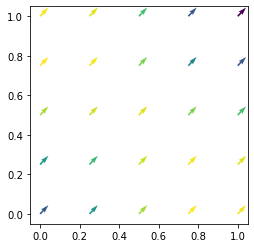

In [33]:
m_hat[0].plot()

In [34]:
print(results['x'])

[ 0.0117046   0.01229254  0.0117042   0.01229316  0.01170471  0.012292
  0.01170217  0.01229327  0.01170436  0.01229282  0.01170306  0.01229015
  0.01169977  0.01229093  0.01170292  0.01229332  0.01170306  0.01229152
  0.01169911  0.01228805  0.01169845  0.01228874  0.01170128  0.01229152
  0.01170316  0.01229339  0.01169969  0.01229     0.01169642  0.01228681
  0.01170067  0.01229003  0.01170307  0.01229312  0.0117012   0.01229328
  0.01169767  0.01228942  0.011703    0.01229241  0.0117025   0.01229454
  0.01169977  0.01229329  0.01170281  0.01229442  0.01170161  0.01229491
  0.01170213  0.01229484  1.80686012  1.80676948 -0.13826596  1.80657392
  1.80669726 -0.13822671  1.80676549  1.8070782  -0.13829461  1.80570074
  1.80675766 -0.13819862  1.80655479  1.80688704 -0.13825476  1.8065788
  1.80786698 -0.13829709  1.80479252  1.80662766 -0.13822526  1.80594447
  1.80694263 -0.13822403  1.80638966  1.80746118 -0.13827569  1.80671321
  1.80864044 -0.13824858  1.80445098  1.80603178 -0.13

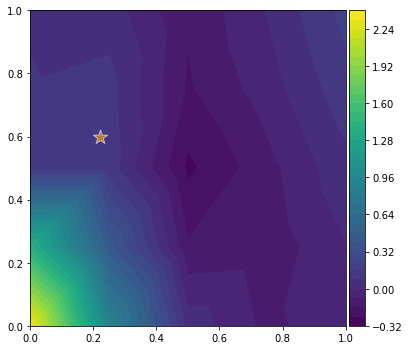

In [29]:
# m_hat.update(results['x'])
u_hat = invp.equation.solve(m_hat)

focal_x = [0.222, 0.6]
u_hat.plot(focal_x)

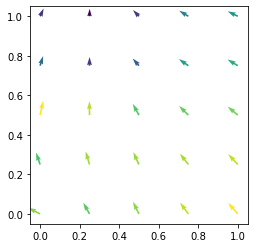

In [28]:
m_hat.update(results['x'])
m_hat[0].plot()

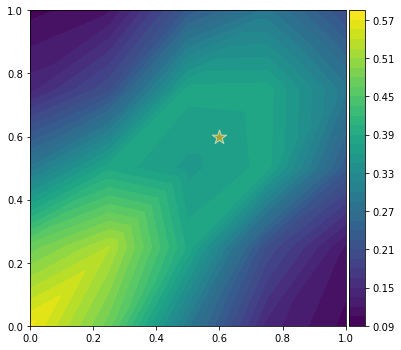

In [23]:
m.update(init_control())
# print(m[0].vector()[:])
# m[0].plot()
u = invp.equation.solve(m)
u.plot(focal_x)

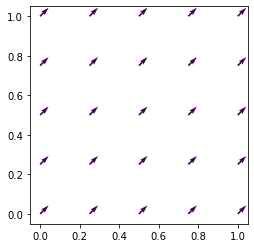

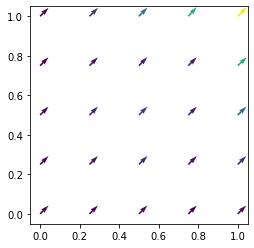

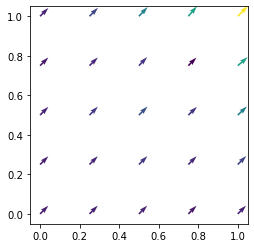

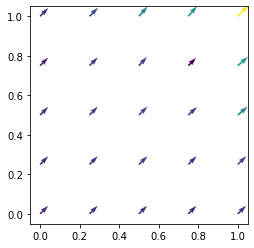

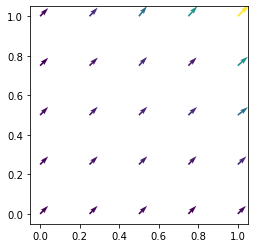

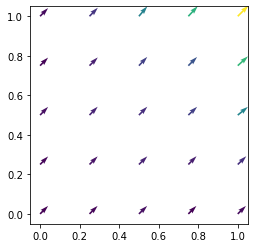

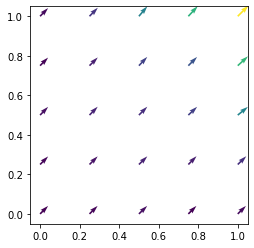

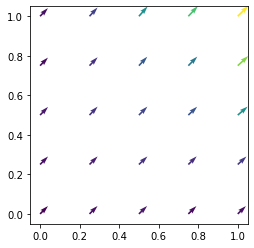

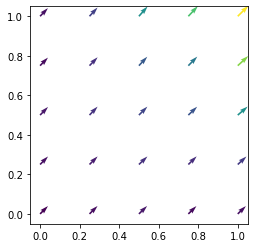

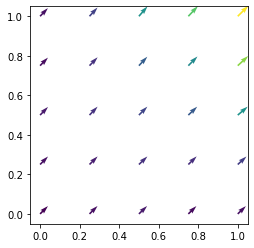

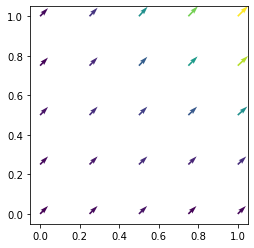

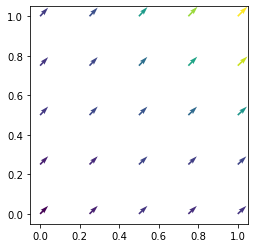

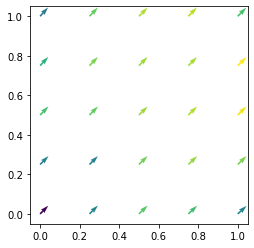

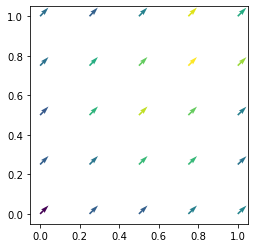

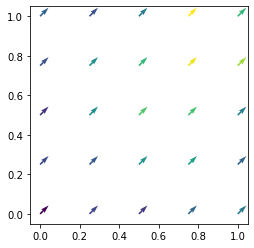

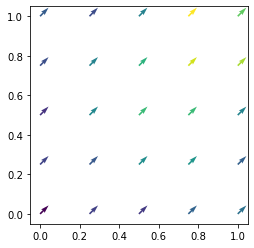

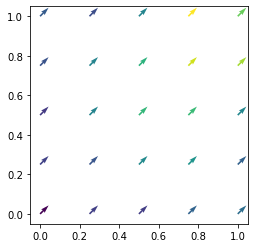

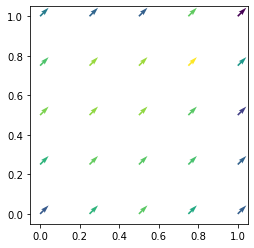

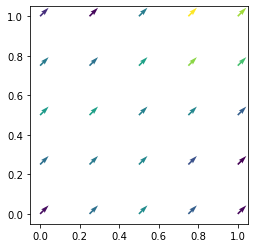

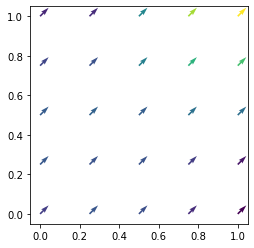

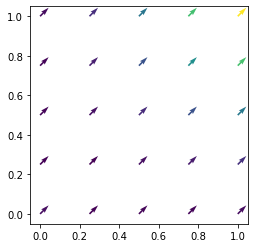

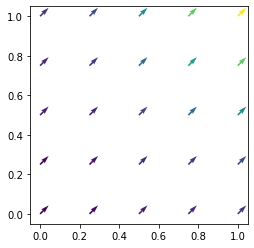

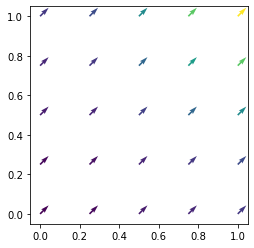

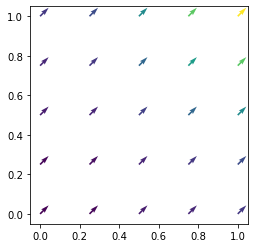

In [31]:
ms = results['allvecs']

for mi in ms:
    m.update(mi)
    m[0].plot()
    plt.show()

In [20]:
Jhat(m)

0.0002921812055672808

In [72]:
loss.l2_error(u)

0.0

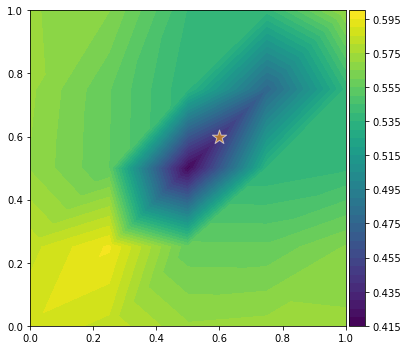

In [59]:
loss.data.plot(focal_x)